In [64]:
#These are the libraries you can use.  You may add any libraries directy related to threading if this is a direction
#you wish to go (this is not from the course, so it's entirely on you if you wish to use threading).  Any
#further libraries you wish to use you must email me, james@uwaterloo.ca, for permission.

from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
import random
from datetime import datetime
from scipy.optimize import minimize

## Group Assignment
### Team Number: 11
### Team Member Names: Akram, Annie, Jester
### Team Strategy Chosen: Market Beat

Disclose any use of AI for this assignment below (detail where and how you used it).  Please see the course outline for acceptable uses of AI.


---
## 📝 **General Strategy for the Project**:

#### Initialization
0) Define and initialize necessary global variables

#### Part #1: Data Filtering and Cleaning
1) Filter out all valid US and CAD Stocks from the provided CSV file (Storing US tickers in another list for currency conversion later on).
2) Download and store closing price, options and volume data in a dictionary using yfinance.
3) Filter out tickers within date range based on given minimum monthly average volume.

#### Part #2: Portfolio Construction
4) Rank stocks based on Standard Deviation of percentage change in returns in descending order.
5) Rank stocks based on PCR values using options data in descending order.
6) Score the stocks based on the two ranks, and create a new ranking based on the scoring.
7) We select stocks based on the ranking and calculate weights that would maximize the portfolio sharpe ratio while beta is within pre-defined constraints.
8) Run sharpe ratio calculation function on portfolio from size 12(min) to 24(max), so that the final portfolio (with weightings) is picked based on highest output sharpe ratio.

#### Part #3: Evaluation and Proof
9) Given the chosen portfolio of xx stocks, graph the change in portfolio standard deviation as other stocks are added.
10) Beta of portfolio compared to the S&P 500.
13) Sharpe ratio between our portfolio with varied weight versus when it is equally weighted.
14) Graphically compare sharpe ratios amongst our portfolio of xx stocks and the portfolios of varying 12-24 stocks.

#### Part #4: Final Output
15) Creating the final portfolio dataframe and CSV.

<br>

--- 

## 🌐 0. Initializing Variables

In [65]:
def get_tickers():
    tickers = pd.read_csv('Tickers.csv')
    ticker_lst = [tickers.columns[0]] + (list(tickers[tickers.columns[0]]))
    return ticker_lst

In [66]:
# Important Constants: 
amount = 1_000_000 # Initial investment amount of $1,000,000
group = 11

# Define constants
min_avg_volume = 100000
min_trading_days = 18
start_date, end_date = '2022-09-30', '2024-09-30'
min_stocks, max_stocks = 12, 24

# Reading in CSV file: 
tickers = pd.read_csv('Tickers.csv')
ticker_lst = get_tickers()

# Initializing variable to store the tickers we will use in our portfolio
columns = ['Ticker', 'Price', 'Currency', 'Shares', 'Value', 'Weight']
Portfolio_Final = pd.DataFrame(columns=columns)
exchange_rate = yf.Ticker('CAD=X').fast_info['last_price']
print(f'The current exchange rate for the latest available day:\nUSD -> CAD: ${np.round(exchange_rate, 4)}')

The current exchange rate for the latest available day:
USD -> CAD: $1.3969


---
## 🧼 1. Data Filtering and Cleaning

**We must filter the tickers csv as follows:**
- Must be listed on yfinance
- The currency is listed as USD or CAD 
- 100,000+ average monthly volume trades
- More than 18 trades per month
- Sufficient data

In [67]:
# Drop tickers with less than 18 days of trading data
def drop_short_trading_months(df):
    """
    Drops months with less than 18 trading days from a yfinance history DataFrame.
    Parameters:
        df (pd.DataFrame): A yfinance DataFrame with a DateTimeIndex and stock data.
    Returns:
        pd.DataFrame: Filtered DataFrame with only months having >= 18 trading days.
    """
    # Ensure the index is datetime for proper grouping
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame index must be a DateTimeIndex.")
    # Group by month and count trading days
    trading_days_per_month = df.groupby(df.index.to_period('M')).size()
    # Identify months with at least 18 trading days
    valid_months = trading_days_per_month[trading_days_per_month >= 18].index
    # Filter the original DataFrame to include only valid months
    filtered_df = df[df.index.to_period('M').isin(valid_months)]
    return filtered_df

In [68]:
# Filtering valid stocks by inputting a list of strings for each ticker. 
def filter_stocks(ticker_lst):
    valid_tickers, invalid_tickers = {}, []
    # Loop through all tickers to check if they are valid
    for ticker in ticker_lst:
        stock = yf.Ticker(ticker)
        try:
            info = stock.fast_info # Get basic stock info

            hist = stock.history(start=start_date, end=end_date) # Get stock history
            hist.index = hist.index.strftime('%Y-%m-%d')

            avg_volume = hist.loc[((hist.index >= start_date) & (hist.index <= end_date))]['Volume'].mean() # Calculate average volume in specified date range.
            currency = info.get("currency")
            if ((hist.empty is not None) and # filter for stocks delisted on yfinance
                ( currency == "USD" or currency == "CAD") and # filter for stocks that are not USD
                (avg_volume >= min_avg_volume)): # Filter by volume greater than 100,000
                if currency == "CAD":
                    valid_tickers[ticker] = hist['Close'] # Store the close prices of the stock as a Series
                elif currency == "USD":
                    valid_tickers[ticker] = hist['Close'] * exchange_rate # Convert USD to CAD
            else:
                invalid_tickers.append(ticker)
        except:
            invalid_tickers.append(ticker)
    return [valid_tickers, invalid_tickers]
    # valid_tickers is a dictionary of Series where the key is the name of the ticker. 
    # invalid_tickers is a list of ticker strings which were removed in the filtering process. 

In [69]:
def calculate_std(data):
    data.index = pd.to_datetime(data.index)
    
    # Calculate daily percentage returns
    returns = data.pct_change().dropna()

    # Calculate standard deviation of returns
    std = pd.DataFrame(returns.std(), columns=['Standard Deviation'])

    # Sort by standard deviation
    std_sorted = std.sort_values(by='Standard Deviation', ascending=False)

    # Add Rank column
    std_sorted['Rank'] = range(len(std_sorted))

    # Add Score column
    highest_std_value = std_sorted['Standard Deviation'].iloc[0]
    std_sorted['Score'] = (std_sorted['Standard Deviation'] / highest_std_value) * 100

    return std_sorted

In [70]:
# Loading data into variables
stock_filter = filter_stocks(ticker_lst)
ticker_data = stock_filter[0]
ticker_lst = list(ticker_data.keys()) # Reassign original ticker list
data = pd.DataFrame()
for ticker in ticker_data:
    data[ticker] = ticker_data[ticker]

# returns = data.pct_change()
# returns.drop(index=returns.index[0], inplace = True)

data.head()

$AGN: possibly delisted; no timezone found
$CELG: possibly delisted; no timezone found
$MON: possibly delisted; no timezone found
$RTN: possibly delisted; no timezone found


,AAPL,ABBV,ABT,ACN,AIG,AMZN,AXP,BA,BAC,BB.TO,...,QCOM,RY.TO,SHOP.TO,T.TO,TD.TO,TXN,UNH,UNP,UPS,USB
Date,,,,,,,,,,,,,,,,,,,,,
2022-09-30,190.728942,172.094812,129.312113,346.667103,63.394073,157.851956,182.816593,169.139072,39.886553,6.51,...,150.566992,113.588982,37.189999,24.323669,76.140350,202.217317,684.835793,259.603665,205.122934,50.947415
2022-10-03,196.594296,177.364990,133.000653,356.893335,65.663860,161.875082,189.741148,176.081766,41.062013,6.53,...,156.217584,114.575356,37.799999,25.033072,77.623253,208.828067,699.033194,266.852618,207.091083,52.526890
2022-10-04,201.631679,182.070920,137.758293,369.585129,69.041852,169.153034,197.112876,186.502777,42.765780,6.74,...,163.080921,117.543625,42.610001,25.316832,79.079208,215.765454,709.420101,273.675200,214.455884,53.866275
2022-10-05,202.045664,183.789168,138.159245,369.625500,68.494432,168.957466,195.635832,184.547098,42.158232,6.67,...,166.439307,117.041313,41.959999,25.104012,78.620857,219.227678,714.708556,267.332340,213.236883,53.322948
2022-10-06,200.706999,179.891067,136.916360,363.064009,67.773436,168.049476,192.939190,184.672815,41.550690,6.64,...,166.959038,113.762520,41.320000,24.421211,75.751678,217.581518,703.941939,264.120954,210.278318,51.907739


---
## 🏗️ 2. Portfolio Construction

In [71]:
# Function to get the total volume for a call or put of a given stock.
# ticker: yfinance Ticker class
# put: Boolean for if you want to calculate put volume. Else, put False for call volume. 
def get_options_vol(ticker, put):
    exps = ticker.options # Expiration dates of available options
    optdata = pd.DataFrame() # Data storage
    for exp in exps:
        chain = pd.DataFrame()
        if put: chain = ticker.option_chain(exp).puts['volume'] # Gets the desired columns
        else: chain = ticker.option_chain(exp).calls['volume'] # If put options are desired then use this data.
        optdata = pd.concat([optdata, chain]) # Add the calls/puts to the main dataframe. 
    return optdata.sum()['volume'] # output total volue of put/call options

# Function to calculate the PCR for each stock. 
def PCR_calc(tickers):
    pcrdata = pd.DataFrame(columns=['Ticker', 'Put Volume', 'Call Volume', 'PCR'])
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        try: 
            # Get the volume for Put and Call options:
            call_options = get_options_vol(stock, False)
            put_options = get_options_vol(stock, True)
            # Calculate PCR Ratio:
            pcr = call_options / put_options # Order reversed from the formula for sake of ranking
            #print(f"Ticker: {ticker}, PCR: {pcr}")  # Debugging
            pcrdata.loc[len(pcrdata)] = [ticker, put_options, call_options, pcr]
        except Exception as e:
            print(f"Options Data Not Found {ticker}: {e} not found")  # Debugging (output error)
            pass
    return pcrdata

In [72]:
std = calculate_std(data)
std

C:\Users\annie\AppData\Local\Temp\ipykernel_3904\2355861676.py:5: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data.pct_change().dropna()


,Standard Deviation,Rank,Score
SHOP.TO,0.036119,0,100.000000
BB.TO,0.034555,1,95.669034
PYPL,0.023802,2,65.898661
QCOM,0.023472,3,64.984562
AMZN,0.021319,4,59.023566
USB,0.021262,5,58.864427
BA,0.020383,6,56.431218
LLY,0.018070,7,50.027409
CAT,0.017667,8,48.911571
TXN,0.016711,9,46.266555


In [73]:
# Load the PCR values for each of the valid stocks into a variable
options_data = PCR_calc(ticker_lst)
options_data = options_data.sort_values(by='PCR', ascending=False)
options_data['Rank'] = [i for i in range(len(options_data))]
highest_pcr = options_data['PCR'].iloc[0]
options_data['Score'] = (options_data['PCR'] / highest_pcr) * 100
options_data.set_index('Ticker', inplace=True)


# Display the table of rankings based off PCR. 
# The rankings are based off the stocks with the greatest sentiment for if they will go up or not
# The tickers at the top of the list have a high call rate (meaning the price will go up)
pcr = options_data
pcr

Options Data Not Found BB.TO: 'volume' not found
Options Data Not Found RY.TO: 'volume' not found
Options Data Not Found SHOP.TO: 'volume' not found
Options Data Not Found T.TO: 'volume' not found
Options Data Not Found TD.TO: 'volume' not found


,Put Volume,Call Volume,PCR,Rank,Score
Ticker,,,,,
KO,11173.0,58728.0,5.256243,0,100.000000
PM,2844.0,10426.0,3.665963,1,69.744942
PG,8260.0,26726.0,3.235593,2,61.557150
PEP,5154.0,15798.0,3.065192,3,58.315269
AMZN,261121.0,660950.0,2.531202,4,48.156110
ABT,3750.0,9479.0,2.527733,5,48.090118
MRK,9984.0,22607.0,2.264323,6,43.078736
LMT,4555.0,9932.0,2.180461,7,41.483264
BK,1664.0,2832.0,1.701923,8,32.379081


In [74]:
def calculate_scoreboard(std, pcr):
    """
    Merges two DataFrames (std and pcr) on their index (assumed to be ticker names),
    calculates the average of their 'Score' columns, and sorts the result by 'Average Score'.
    """

    merged = std[['Score']].merge(pcr[['Score']], left_index=True, right_index=True, suffixes=('_std', '_pcr'), how='outer')

    # interesting case here, we need to consider stocks with nan from PCR strategy
    merged['Score_std'].fillna(merged['Score_pcr'], inplace=True)
    merged['Score_pcr'].fillna(merged['Score_std'], inplace=True)
    
    # Calculate the average score
    merged['Average Score'] = merged[['Score_std', 'Score_pcr']].mean(axis=1)
    
    # Sort the DataFrame by 'Average Score' in descending order
    merged_sorted = merged.sort_values(by='Average Score', ascending=False)
    
    return merged_sorted

calculate_scoreboard(std, pcr)

C:\Users\annie\AppData\Local\Temp\ipykernel_3904\1719902720.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged['Score_std'].fillna(merged['Score_pcr'], inplace=True)
C:\Users\annie\AppData\Local\Temp\ipykernel_3904\1719902720.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a c

,Score_std,Score_pcr,Average Score
SHOP.TO,100.000000,100.000000,100.000000
BB.TO,95.669034,95.669034,95.669034
KO,24.033253,100.000000,62.016627
AMZN,59.023566,48.156110,53.589838
PM,29.544162,69.744942,49.644552
PYPL,65.898661,32.023512,48.961087
QCOM,64.984562,23.905048,44.444805
PG,26.580892,61.557150,44.069021
PEP,28.227764,58.315269,43.271517
ABT,36.020765,48.090118,42.055442


In [93]:
# Load market data into a dataframe
s_p500 = yf.Ticker('^GSPC').history(start=start_date, end=end_date)['Close']
tsx60 = yf.Ticker('^GSPTSE').history(start=start_date, end=end_date)['Close']

SPreturns = s_p500.pct_change().dropna()
TSX60Returns = tsx60.pct_change().dropna()

avg_return = (SPreturns + TSX60Returns)/2

market_indices = pd.DataFrame({'S&P 500 PCT Returns': SPreturns, 
                               'TSX 60 PCT Returns': TSX60Returns, 
                               'Average Market Return': avg_return})
market_indices.index = market_indices.index.strftime('%Y-%m-%d')
market_indices.index = pd.to_datetime(market_indices.index)

market_indices.head()

,S&P 500 PCT Returns,TSX 60 PCT Returns,Average Market Return
Date,,,
2022-10-03,0.025884,0.023693,0.024788
2022-10-04,0.030584,0.025941,0.028262
2022-10-05,-0.002018,-0.007016,-0.004517
2022-10-06,-0.010245,-0.013314,-0.011780
2022-10-07,-0.028004,-0.020860,-0.024432


In [94]:
market_variance = market_indices['Average Market Return'].var()
print(f'Market Variance: {market_variance}')

Market Variance: 6.424001518121877e-05


In [ ]:
# sharpe ratio optimization

def optimal_sharpe(tickers, start_date, end_date, risk_free_rate, investment):
    # creating prices dataframe
    prices = pd.DataFrame()

    for ticker in data.columns.tolist():
        if ticker in tickers:
            prices[ticker] = data[ticker]

    def neg_sharpe(weights):

        # determining number of shares of each stock that can be bought
        shares = []
        for i in range(len(tickers)):
            allocation = investment * weights[i]  # investment allocated to this stock
            price_per_share = prices.iloc[0][tickers[i].upper()]
            
            # clculate fees
            flat_fee = 3.95
            per_share_fee = allocation/price_per_share/(1000+1/price_per_share) 
            
            # choose the smaller of the two fees
            trading_fee = min(flat_fee, per_share_fee)
            
            # calculate the number of shares after deducting the fee
            effective_investment = allocation - trading_fee
            shares.append(effective_investment / price_per_share)
        
        # forming the portfolio
        portfolio = prices*shares
        portfolio['total'] = portfolio.sum(axis=1)
        portfolio['daily return'] = portfolio['total'].pct_change(1)

        # calculating sharpe ratio
        er = portfolio['daily return'].mean()
        std = portfolio['daily return'].std()
        sharpe_ratio = (er-risk_free_rate)/std
        
        sharpe_ratio = sharpe_ratio*(252**0.5) # annualizing sharpe ratio by trading days

        return -sharpe_ratio #make sharpe ratio negative for minimize function

    # constraints
    def check_sum(weights): 
        return np.sum(weights)-1 #returns 0 if weights sum up to 1

    def check_beta(weights):
        # creating prices dataframe
        prices = pd.DataFrame()

        for ticker in data.columns.tolist():
            if ticker in tickers:
                prices[ticker] = data[ticker]

        # initializing
        betas = []
        portfolio_beta = 0

        snp = yf.Ticker('^GSPC').history(start=start_date, end=end_date)['Close']
        tse = yf.Ticker('^GSPTSE').history(start=start_date,end=end_date)['Close']
        market = (snp+tse)/2
        
        # calculate individual stock betas
        for ticker in tickers:
            compare = pd.DataFrame()
            compare['stock'] = prices[ticker].pct_change(fill_method=None).dropna()
            compare['market'] = market_indices['Average Market Return']
            beta = (compare.cov()/compare['market'].var()).iat[0,1]
            betas.append(beta)

        # calculate portfolio beta with weighted stock betas
        for i in range(len(weights)):
            portfolio_beta += betas[i] * weights[i]

        return portfolio_beta - 1
    
    constraints = [
        {'type': 'eq', 'fun': check_sum},
        {'type': 'ineq', 'fun': check_beta}
    ]

    min_weight = 1/(2*len(tickers))
    max_weight = 0.4

    bounds = [(min_weight, max_weight)]*len(tickers)

    # initial guess
    init_guess = [1.0/len(tickers)]*len(tickers)

    results = minimize(neg_sharpe, init_guess, method="SLSQP", bounds=bounds, constraints=constraints)

    return results

optimal = optimal_sharpe(ticker_lst, start_date, end_date, 0, 1000000)
print(optimal.fun)

-1.5303528988890729


In [ ]:
# Calculating beta of the stock portfolio

for i in range(min_stocks, max_stocks+1):
    current_stocks = list(scores.head(i).index)
    stock_weight_data = optimal_sharpe(current_stocks, 0, amount)
    weights = stock_weight_data.x
    sharpe_ratio = -stock_weight_data.fun

    if current_best is None or (sharpe_ratio > current_best[0] and portfolio_beta > current_best[1]):
        current_best = (sharpe_ratio, portfolio_beta, current_stocks, weights)
    
print(f'''
      Best Sharpe Ratio: {current_best[0]}
      Best Portfolio Beta: {current_best[1]}
      Number of Stocks: {len(current_best[2])}
''')

---
## 🔍 3. Evaluation and Proof

# graphs stuff
9) Given the chosen portfolio of xx stocks, graph the change in portfolio standard deviation as other stocks are added.
10) Beta of portfolio compared to the S&P 500.


C:\Users\annie\AppData\Local\Temp\ipykernel_3904\2798701153.py:18: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  market_returns = market.pct_change().dropna()


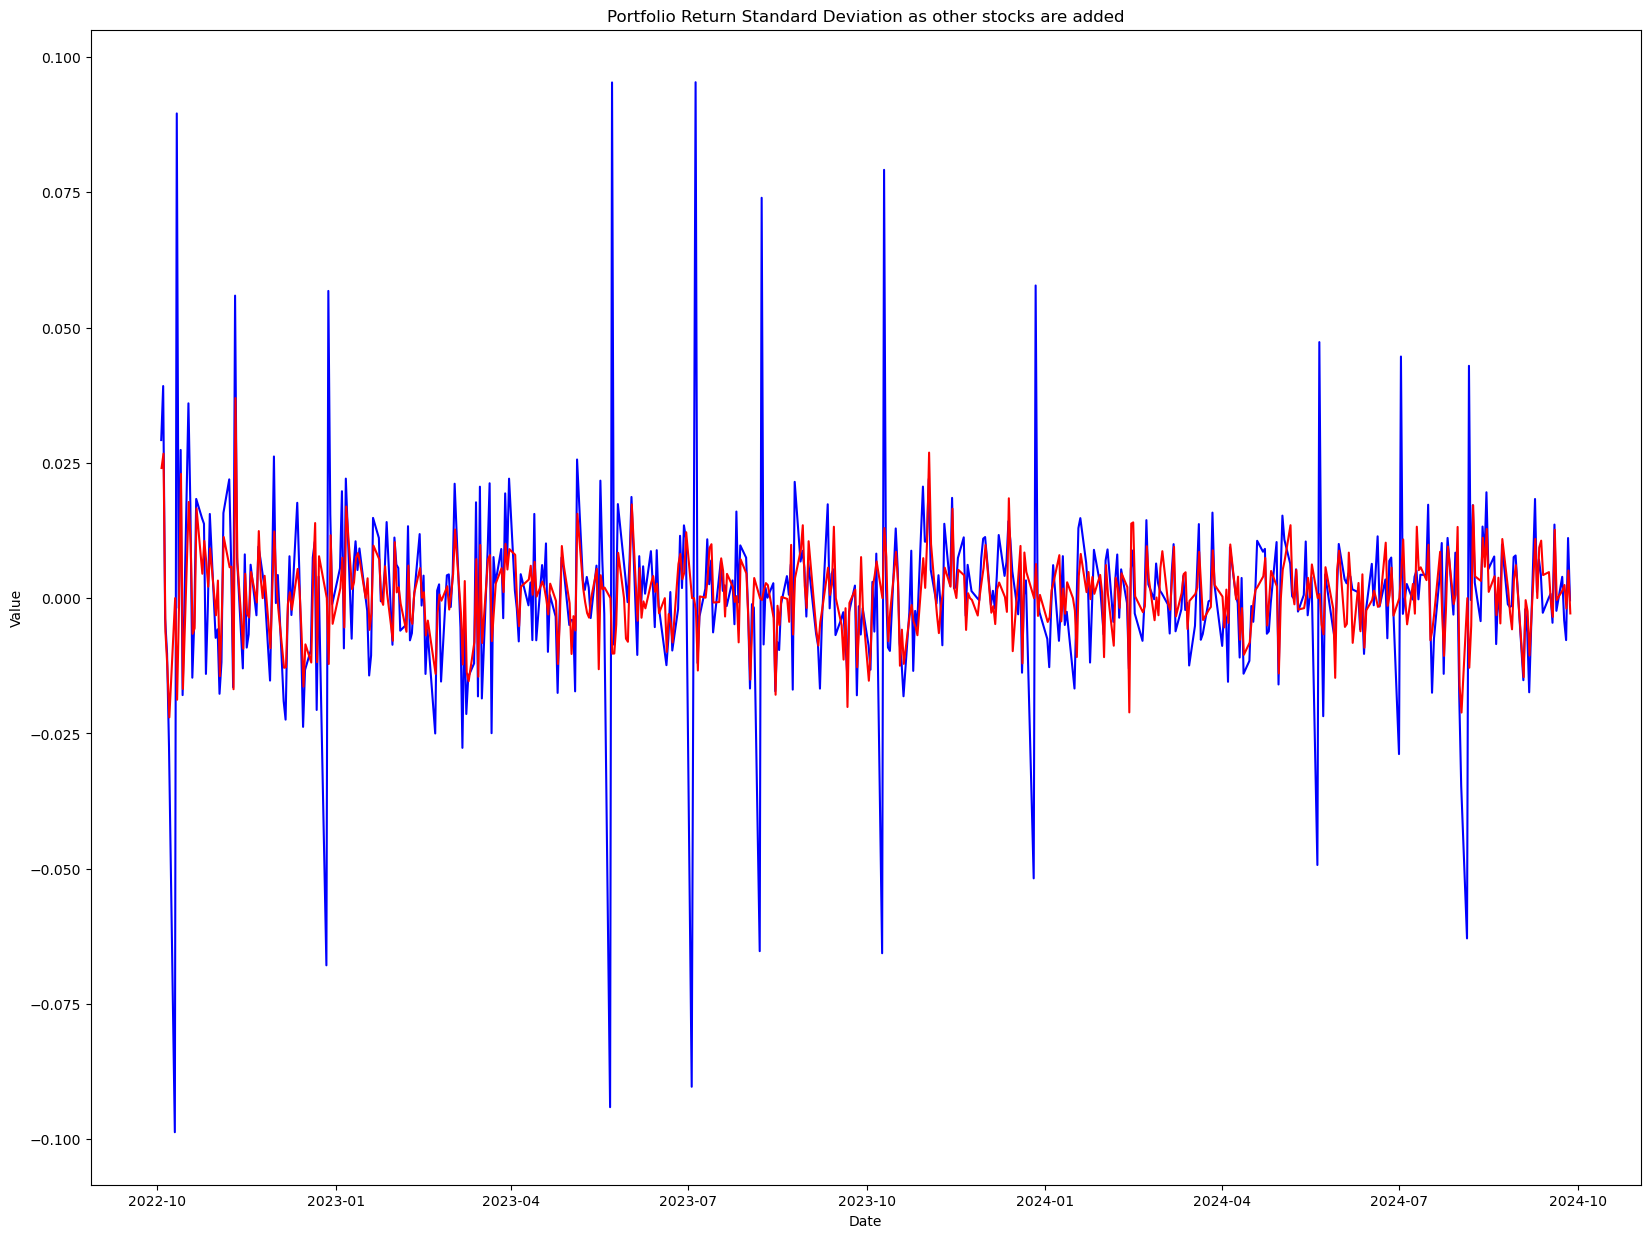

In [ ]:
weights = [1/10]*10
shares = []

for i in range(len(weights)):
            allocation = amount * weights[i]  # investment allocated to this stock
            price_per_share = data.iloc[0][ticker_lst[i].upper()]
            shares.append(allocation / price_per_share)

test_portfolio = data.iloc[:, :10]*shares
test_portfolio['value'] = test_portfolio.sum(axis=1)

test_portfolio_returns = test_portfolio['value'].pct_change().dropna()

snp = yf.Ticker('^GSPC').history(start=start_date, end=end_date)['Close']
tse = yf.Ticker('^GSPTSE').history(start=start_date,end=end_date)['Close']

market = (snp+tse)/2
market_returns = market.pct_change().dropna()

plt.figure(figsize=(20,15))

plt.plot(test_portfolio_returns, color='b')
plt.plot(market_returns, color='r')
plt.title('Portfolio Return Standard Deviation as other stocks are added')
plt.xlabel('Date')
plt.ylabel('Value')

plt.show()

---
## 🏁 4. Final Output

In [ ]:
# Code to output final dataframe to a CSV file called Stocks_Group_XX.csv
Stocks_Final = Portfolio_Final[['Ticker', 'Shares']]
Stocks_Final.to_csv(f'Stocks_Group_{group}.csv', index=False)

In [ ]:
Portfolio_Final

,Ticker,Price,Currency,Shares,Value,Weight


---

## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

<p style="color: #004dd3">
Akram Jamil
</p>

<p style="color: #2C8CA9">
Jester Yang
</p>

<p style="color: #3cc19d;">
Annie Wong
</p>

---

thanks for reading ♥️